In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install -q catboost
from catboost import CatBoostClassifier

In [3]:
clients = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/data/clients2.csv')
clients = clients.drop('client_id.1', axis=1)
print(clients.shape)
clients.head()

(200039, 5)


,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
3,0001f552b0,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
4,00020e7b18,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U


In [4]:
clients.age.describe()

count    200039.000000
mean         46.417329
std          49.532475
min       -7491.000000
25%          34.000000
50%          45.000000
75%          59.000000
max        1852.000000
Name: age, dtype: float64

In [5]:
age_upper = np.quantile(clients.age, 0.99)
age_lower = np.quantile(clients.age, 0.01)
clients.loc[clients.age > age_upper, 'age'] = age_upper
clients.loc[clients.age < age_lower, 'age'] = age_lower
print(clients.shape)
clients.head()

(200039, 5)


,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,82,U
3,0001f552b0,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
4,00020e7b18,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U


In [6]:
clients.first_issue_date = pd.to_datetime(clients.first_issue_date)
clients.first_redeem_date = pd.to_datetime(clients.first_redeem_date)
clients.first_issue_date = clients.first_issue_date.dt.date
clients.first_redeem_date = clients.first_redeem_date.dt.date
clients.head()

,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05,2018-01-04,45,U
1,000036f903,2017-04-10,2017-04-23,72,F
2,00010925a5,2018-07-24,2018-09-14,82,U
3,0001f552b0,2017-06-30,2018-08-28,33,F
4,00020e7b18,2017-11-27,2018-01-10,73,U


In [7]:
clients['diff_first_date'] = (clients.first_redeem_date - clients.first_issue_date) / np.timedelta64 ( 1 , 'D')
clients.diff_first_date = clients.diff_first_date.fillna(0)
clients.head()

,client_id,first_issue_date,first_redeem_date,age,gender,diff_first_date
0,000012768d,2017-08-05,2018-01-04,45,U,152.0
1,000036f903,2017-04-10,2017-04-23,72,F,13.0
2,00010925a5,2018-07-24,2018-09-14,82,U,52.0
3,0001f552b0,2017-06-30,2018-08-28,33,F,424.0
4,00020e7b18,2017-11-27,2018-01-10,73,U,44.0


In [8]:
train_pd = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/data/train.csv').sort_values('client_id')
print(train_pd.shape)
train_pd.head()

(140027, 3)


,client_id,treatment_flg,purchased
131753,000012768d,0,1
68637,000036f903,1,1
116599,0001f552b0,1,1
131167,00020e7b18,1,1
39183,000220a0a7,0,1


In [9]:
train_purch = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/train_purch/train_purch.csv')
print(train_purch.shape)
train_purch.head()

(15998952, 13)


,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


In [10]:
products = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/data/products.csv')
print(products.shape)
products.head()

(43038, 11)


,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.400,0,0
1,0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680,0,0
2,0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500,0,0
3,000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
4,0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600,0,0


In [11]:
test_pd = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/data/test.csv').sort_values('client_id')
print(test_pd.shape)
test_pd.head()

(60012, 1)


,client_id
40975,00010925a5
38110,00035a21d9
37732,00038f9200
24076,0004315e57
12779,0006fca4bf


In [12]:
test_purch = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/test_purch/test_purch.csv')
print(test_purch.shape)
test_purch.head()

(6883738, 13)


,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,a375a035b9,2.0,50.0,NaN
1,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,6f9e02ee36,1.0,90.0,NaN
2,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,42e1eb8d23,1.0,20.0,NaN
3,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,5c6de3010f,2.0,85.0,NaN
4,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,343e841aaa,1.0,58.0,NaN


In [13]:
def prepare_data(data):
    s = data.drop(columns=['regular_points_received','express_points_received',
                           'regular_points_spent', 'express_points_spent',
                           'store_id', 'product_quantity',
                           'trn_sum_from_iss','trn_sum_from_red'])
    s = s.drop_duplicates()
    dop_s = data[['transaction_id','product_id']].merge(products[['product_id','is_own_trademark','is_alcohol']], on='product_id')
    dop_s = dop_s.groupby('transaction_id', as_index=False)\
    .agg({'product_id':'count','is_own_trademark':'sum','is_alcohol':'sum'})\
    .rename(columns={'product_id':'product_cnt','is_own_trademark':'trademark_cnt','is_alcohol':'alcohol_cnt'})
    s = s.drop('product_id', axis=1)
    
    s = s.merge(dop_s, on='transaction_id').drop_duplicates()
    s1 = s.groupby('client_id').agg({'transaction_id':'count',
                                 'purchase_sum':'sum',
                                 'product_cnt':'sum',
                                 'trademark_cnt':'sum',
                                 'alcohol_cnt':'sum'})
    new_train = clients[['client_id', 'age', 'gender','diff_first_date']].merge(s1, on='client_id')
    new_train['gender'] = new_train.gender.map({'F':0,'M':1,'U':2})
    return new_train.sort_values('client_id')

In [14]:
train_purch = prepare_data(train_purch)
train_purch

,client_id,age,gender,diff_first_date,transaction_id,purchase_sum,product_cnt,trademark_cnt,alcohol_cnt
0,000012768d,45,2,152.0,4,2803.00,52,4,0
1,000036f903,72,0,13.0,32,9805.00,162,14,1
2,0001f552b0,33,0,424.0,15,6155.18,86,10,0
3,00020e7b18,73,2,44.0,18,25819.61,272,44,0
4,000220a0a7,82,1,299.0,15,8606.57,85,16,1
...,...,...,...,...,...,...,...,...,...
140022,fffd5cd0c6,47,1,454.0,18,5731.63,100,20,0
140023,fffd63dfe3,31,2,266.0,4,1340.51,25,10,4
140024,fffd8c9d7d,48,0,130.0,5,1636.53,20,7,0
140025,fffe0abb97,35,0,76.0,9,2716.42,38,3,0


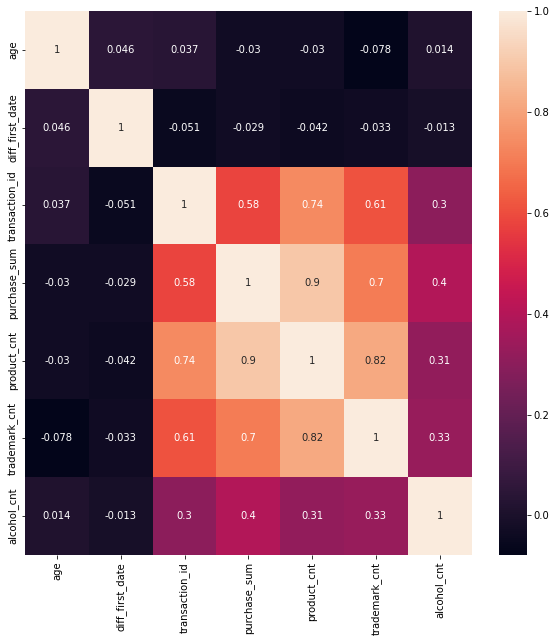

In [15]:
plt.figure(figsize=(10,10))
corr = train_purch.drop(columns=['client_id','gender']).corr()
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cbar=True, annot=True)
plt.show()

In [16]:
train_purch = train_purch.merge(train_pd, on='client_id')
# CN
train_purch['target'] = 0
# CR
train_purch.loc[(train_purch.treatment_flg==0) & (train_purch.purchased==1), 'target'] = 1
# TN
train_purch.loc[(train_purch.treatment_flg==1) & (train_purch.purchased==0), 'target'] = 2
# TR
train_purch.loc[(train_purch.treatment_flg==1) & (train_purch.purchased==1), 'target'] = 3
train_purch.head()

,client_id,age,gender,diff_first_date,transaction_id,purchase_sum,product_cnt,trademark_cnt,alcohol_cnt,treatment_flg,purchased,target
0,000012768d,45,2,152.0,4,2803.00,52,4,0,0,1,1
1,000036f903,72,0,13.0,32,9805.00,162,14,1,1,1,3
2,0001f552b0,33,0,424.0,15,6155.18,86,10,0,1,1,3
3,00020e7b18,73,2,44.0,18,25819.61,272,44,0,1,1,3
4,000220a0a7,82,1,299.0,15,8606.57,85,16,1,0,1,1


In [17]:
x_train, x_val, y_train, y_val, treat_train, treat_val = train_test_split(
    train_purch.drop(columns=['treatment_flg','purchased']),
    train_purch.purchased,
    train_purch.treatment_flg,
    test_size = 0.3,
    random_state = 42
)

In [18]:
def SingleModel(x_train, y_train, treat_train, x_val):
    x_train = x_train.drop(['client_id','target'], axis=1)
    x_mod = x_train.assign(treatment = treat_train)
    est = CatBoostClassifier(verbose=100, cat_features=['gender'], random_state=42).fit(x_mod, y_train)

    if 'target' in x_val.columns:
        x_val = x_val.drop(['client_id','target'], axis =1)
    else:
        x_val = x_val.drop(['client_id'], axis=1)
        
    x_mod_trmnt = x_val.assign(treatment = np.ones(x_val.shape[0]))
    x_mod_ctrl = x_val.assign(treatment = np.zeros(x_val.shape[0]))
    
    trmnt_pred = est.predict_proba(x_mod_trmnt)[:, 1]
    ctrl_pred = est.predict_proba(x_mod_ctrl)[:, 1]
    uplift = trmnt_pred - ctrl_pred
    
    return uplift

In [19]:
uplift = SingleModel(x_train, y_train, treat_train, x_val)
df_u = pd.DataFrame(data={'client_id':x_val.client_id,
                          'score': uplift,
                          'target': x_val.target})
df_u

Learning rate set to 0.072983
0:	learn: 0.6738448	total: 144ms	remaining: 2m 24s
100:	learn: 0.5596646	total: 5.25s	remaining: 46.8s
200:	learn: 0.5564710	total: 9.75s	remaining: 38.8s
300:	learn: 0.5529188	total: 14.5s	remaining: 33.7s
400:	learn: 0.5497703	total: 19.3s	remaining: 28.8s
500:	learn: 0.5465728	total: 24.2s	remaining: 24.1s
600:	learn: 0.5439956	total: 28.9s	remaining: 19.2s
700:	learn: 0.5416689	total: 33.7s	remaining: 14.4s
800:	learn: 0.5390460	total: 39s	remaining: 9.7s
900:	learn: 0.5363870	total: 43.8s	remaining: 4.81s
999:	learn: 0.5341152	total: 48.5s	remaining: 0us


,client_id,score,target
47104,55a167d5a4,0.063456,0
78704,8fcc7048e1,0.049041,3
39628,482935ba70,0.058997,2
27882,32d0d35afd,0.022652,2
120258,dbe0f04e14,0.009038,1
...,...,...,...
97298,b21ba3ff38,0.001534,1
32011,3a228ec82d,0.046085,0
135278,f74fe30e1f,0.096095,0
54263,62e7725949,0.031416,1


In [20]:
def qini_rank(uplift:pd.DataFrame):
   
    ranked = pd.DataFrame({'n':[], 'target_class':[]})
    ranked['target_class'] = uplift['target']
    ranked['uplift_score'] = uplift['score']
    

    ranked['n'] = ranked.uplift_score.rank(pct=True, ascending=False)  
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked

def qini_eval(ranked:pd.DataFrame):

    uplift_model, random_model = ranked.copy(), ranked.copy()
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1],5)
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)
    return merged

def qini_plot(merged:pd.DataFrame):

    ax = sns.lineplot(x='n', y='uplift', hue='model', data=merged,
                      style='model', palette=['red','grey'])
 
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=15)
    plt.ylabel('Uplift',fontsize=15)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=12)
    plt.title('SingleModel by CatBoostClf')
    plt.grid(True)
    ax.tick_params(labelsize=15)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    return ax

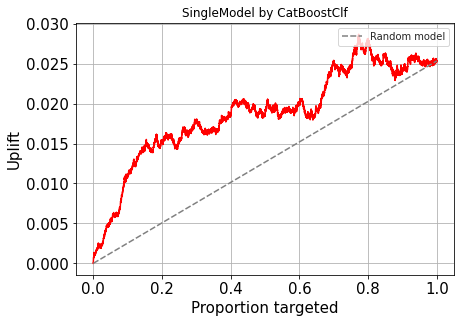

In [21]:
ranked = qini_rank(df_u)
merged = qini_eval(ranked)
ax = qini_plot(merged)

In [22]:
test_purch = prepare_data(test_purch)
print(test_purch.shape)
test_purch.head()

(60012, 9)


,client_id,age,gender,diff_first_date,transaction_id,purchase_sum,product_cnt,trademark_cnt,alcohol_cnt
0,00010925a5,82,2,52.0,18,5883.00,78,9,1
1,00035a21d9,69,2,21.0,3,1791.94,26,1,0
2,00038f9200,79,2,36.0,48,8385.00,158,14,0
3,0004315e57,38,2,69.0,14,7590.00,122,22,0
4,0006fca4bf,57,2,0.0,3,2141.00,28,4,1


In [23]:
test_uplift = SingleModel(train_purch.drop(columns=['treatment_flg','purchased']),
                          train_purch.purchased, train_purch.treatment_flg, test_purch)

Learning rate set to 0.08499
0:	learn: 0.6711652	total: 70.8ms	remaining: 1m 10s
100:	learn: 0.5598853	total: 6.39s	remaining: 56.9s
200:	learn: 0.5572559	total: 12.8s	remaining: 51.1s
300:	learn: 0.5542795	total: 19.7s	remaining: 45.7s
400:	learn: 0.5517937	total: 26.7s	remaining: 39.8s
500:	learn: 0.5492099	total: 33.3s	remaining: 33.1s
600:	learn: 0.5470199	total: 39.8s	remaining: 26.4s
700:	learn: 0.5447507	total: 46.5s	remaining: 19.8s
800:	learn: 0.5426827	total: 53.6s	remaining: 13.3s
900:	learn: 0.5404552	total: 1m	remaining: 6.62s
999:	learn: 0.5383900	total: 1m 6s	remaining: 0us


In [24]:
result_pd = pd.DataFrame(data={'client_id': test_purch.client_id,
                               'pred': test_uplift})
result_pd

,client_id,pred
0,00010925a5,0.072890
1,00035a21d9,0.164250
2,00038f9200,0.019271
3,0004315e57,0.039626
4,0006fca4bf,0.003923
...,...,...
60007,fff9aa288c,0.036654
60008,fff9f772f6,0.019068
60009,fffe0ed719,0.025034
60010,fffea1204c,0.086821


In [25]:
baseline = pd.read_csv('/kaggle/input/uplift-shift-23/baseline.csv').sort_values('client_id')
print(baseline.shape)
baseline.head()

(60012, 2)


,client_id,pred
40975,00010925a5,0.528987
38110,00035a21d9,0.521113
37732,00038f9200,0.537992
24076,0004315e57,0.511788
12779,0006fca4bf,0.520180


In [26]:
result_pd.merge(baseline, on='client_id')

,client_id,pred_x,pred_y
0,00010925a5,0.072890,0.528987
1,00035a21d9,0.164250,0.521113
2,00038f9200,0.019271,0.537992
3,0004315e57,0.039626,0.511788
4,0006fca4bf,0.003923,0.520180
...,...,...,...
60007,fff9aa288c,0.036654,0.510854
60008,fff9f772f6,0.019068,0.521113
60009,fffe0ed719,0.025034,0.521760
60010,fffea1204c,0.086821,0.525875


In [27]:
result_pd.to_csv('uplift.csv', index=False)